# 03. 實作多層神經網路

## 目錄

- 使用手寫數字來進行分類
- 實作多層感知機 (MLP)

# 使用手寫數字來進行分類

## 讀取 MNIST 資料集

MNIST 資料集可以在這裡下載: [http://yann.lecun.com/exdb/mnist/](http://yann.lecun.com/exdb/mnist/)

檔案:
- train-images-idx3-ubyte.gz: 訓練集圖片
- train-labels-idx1-ubyte.gz: 訓練集標籤
- t10k-images-idx3-ubyte.gz: 測試集圖片
- t10k-labels-idx1-ubyte.gz: 測試集標籤

In [16]:
MNIST = [
    "train-images-idx3-ubyte.gz",
    "train-labels-idx1-ubyte.gz",
    "t10k-images-idx3-ubyte.gz",
    "t10k-labels-idx1-ubyte.gz"
]

### 安裝 wget 套件

In [17]:
# 使用 '!' 來執行系統指令
!pip install wget


[notice] A new release of pip is available: 23.2.1 -> 23.3
[notice] To update, run: pip install --upgrade pip


### 下載 MNIST 資料集

In [18]:
# 匯入 os 套件
import os

# 設置 MNIST 資料集位置
# mnist_dir = "/content/mnist"
mnist_dir = "resources/mnist"
os.makedirs(mnist_dir, exist_ok=True)

In [19]:
# 匯入 wget 套件
import wget

# 下載資料集
for filename in MNIST:
    wget.download(f"http://yann.lecun.com/exdb/mnist/{filename}", mnist_dir)

### 解開 MNIST 壓縮

In [20]:
# 匯入 gzip 套件
import gzip

for filename in MNIST:
    z = os.path.join(mnist_dir, filename)
    with gzip.GzipFile(z, mode="rb") as decompressed, open(z[:-3], 'wb') as outfile:
        outfile.write(decompressed.read())

### 讀取 MNIST 資料

In [21]:
# 匯入 os, struct, numpy 套件
import struct
import numpy as np

# 撰寫讀取 MNIST 資料集
def load_mnist(path, kind='train'):
    labels_path = os.path.join(path, '%s-labels-idx1-ubyte' % kind)
    images_path = os.path.join(path, '%s-images-idx3-ubyte' % kind)

    with open(labels_path, "rb") as label_path:
        magic, n = struct.unpack('>II', label_path.read(8))
        labels = np.fromfile(label_path, dtype=np.uint8)

    with open(images_path, "rb") as image_path:
        magic, num, rows, cols = struct.unpack('>IIII', image_path.read(16))
        images = np.fromfile(image_path, dtype=np.uint8)
        images = images.reshape(len(labels), 28*28)
        images = ((images / 255.) - .5) * 2

    return images, labels

#### 訓練集

In [22]:
# 顯示訓練集
x_train, y_train = load_mnist(mnist_dir, kind="train")
print("Rows: %d, Columns: %d" % (x_train.shape[0], x_train.shape[1]))

Rows: 60000, Columns: 784


#### 測試集

In [23]:
# 顯示測試集
x_test, y_test = load_mnist(mnist_dir, kind="t10k")
print("Rows: %d, Columns: %d" % (x_train.shape[0], x_train.shape[1]))

Rows: 60000, Columns: 784


#### 顯示每個數字的第一張影像

[]

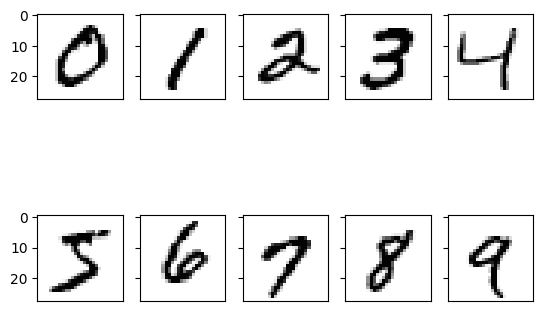

In [24]:
# 匯入 matplotlib 的畫布套件
import matplotlib.pyplot as plt

# 顯示 0~9 的手寫影像
fig, ax = plt.subplots(nrows=2, ncols=5, sharex=True, sharey='all')
ax = ax.flatten()

for i in range(10):
    img = x_train[y_train == i][0].reshape(28, 28)
    ax[i].imshow(img, cmap='Greys')

ax[0].set_xticks([])

#### 顯示 25 種不同版本的數字 7:

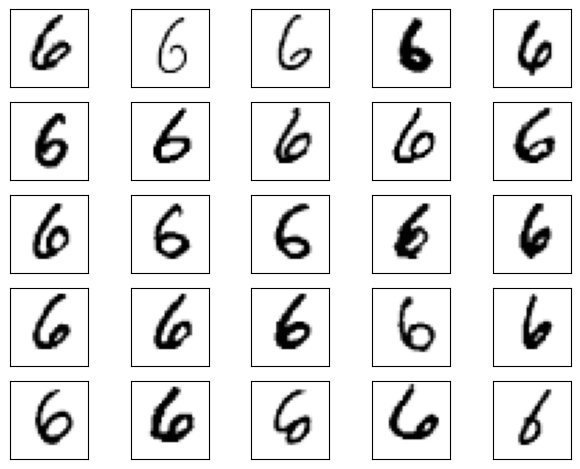

In [25]:
# 顯示多個版本的同樣數字的手寫影像
fig, ax = plt.subplots(nrows=5, ncols=5, sharex=True, sharey=True)
ax = ax.flatten()

for i in range(5 * 5):
    img = x_train[y_train == 6][i].reshape(28, 28)
    ax[i].imshow(img, cmap="Greys")

ax[0].set_xticks([])
ax[0].set_yticks([])

plt.tight_layout()
plt.show()

### 使用 Numpy 建立 MNIST 快取

In [26]:
# 快取儲存位置
output_dir = os.path.abspath("resources/mnist")
# output_dir = os.path.abspath("/content/mnist")
os.makedirs(output_dir, exist_ok=True)

# 建立快取
output_filepath = os.path.join(output_dir, "mnist_scaled.npz")
np.savez_compressed(
    output_filepath,
    x_train=x_train,
    y_train=y_train,
    x_test=x_test,
    y_test=y_test
)

#### 讀入 MNIST 快取

In [27]:
# 讀取快取
mnist = np.load(output_filepath)
mnist.files

['x_train', 'y_train', 'x_test', 'y_test']

In [28]:
# 讀取快取
x_train, y_train, x_test, y_test = [
    mnist[filename]
    for filename
    in ['x_train', 'y_train', 'x_test', 'y_test']
]
x_train.shape

(60000, 784)

# 實作多層感知機 (MLP)

In [29]:
# 匯入套件 numpy, sys

# 實作多層感知器 MLP
class NeuralNetMLP:
    """ 前向傳播神經網路 / 多層感知器分類器

    參數
    ------------
    n_hidden : int (default: 30)
        隱藏單元數量.
    l2 : float (default: 0.)
        L2 正規化的 lambda 值
        如果 l2=0. 不進行正規化 (default)
    epochs : int (default: 100)
        訓練集的傳遞次數。 (回合數)
    eta : float (default: 0.001)
        學習綠.
    shuffle : bool (default: True)
        如果為 True，則在每個 Epoch 對訓練資料進行洗牌以防止循環。
    minibatch_size : int (default: 1)
        每個小批量的訓練樣本數。
    seed : int (default: None)
        用於初始化權重和洗牌的隨機種子。

    屬性
    -----------
    eval_ : dict
      收集訓練期間每個 EPOCH 的 cost、訓練正確率和驗證正確率。

    """
    def __init__(self, n_hidden=30, l2=0., epochs=100, eta=0.001,
                 shuffle=True, minibatch_size=1, seed=None):
        self._random = np.random.RandomState(seed)
        self._n_hidden = n_hidden
        self._l2 = l2
        self.epochs = epochs
        self._eta = eta
        self._shuffle = shuffle
        self._minibatch_size = minibatch_size
        self.eval_ = None
        self._w_out = None
        self._b_out = None
        self._w_h = None
        self._b_h = None

    def _onehot(self, y, n_classes):
        """編碼標籤為 one-hot 表達式

        參數
        ------------
        y : array, shape = [n_examples]
            目標值. (label)
        n_classes : int
            類別數量

        回傳
        -----------
        onehot : array, shape = (n_examples, n_labels)

        """

    def _sigmoid(self, _z):
        """計算邏輯函數（sigmoid）"""

    def _forward(self, _x):
        """計算前向傳播"""

        # 第一步: 計算隱藏層的網路
        # [n_examples, n_features] dot [n_features, n_hidden]
        # -> [n_examples, n_hidden]

        # 第二步: 活化隱藏層
        
        # 第三步: 計算輸出層的網路
        # [n_examples, n_hidden] dot [n_hidden, n_classlabels]
        # -> [n_examples, n_classlabels]

        # step 4: 活化輸出層

    def _compute_cost(self, y_enc, output):
        """計算成本函數

        參數
        ----------
        y_enc : array, shape = (n_examples, n_labels)
            one-hot 編碼的類別標籤
        output : array, shape = [n_examples, n_output_units]
            活化輸出層 (前向傳遞)

        回傳
        ---------
        cost : float
            正規化成本

        """

    def predict(self, _x):
        """預測類別標籤

        參數
        -----------
        _x : array, shape = [n_examples, n_features]
            輸入層的原始特徵

        Returns:
        ----------
        y_pred : array, shape = [n_examples]
            預設的類別標籤.

        """

    def fit(self, _x_train, _y_train, _x_valid, _y_valid):
        """ 從訓練資料學習權重

        參數
        -----------
        _x_train : array, shape = [n_examples, n_features]
            給輸入層的原始特徵
        _y_train : array, shape = [n_examples]
            目標類別標籤
        _x_valid : array, shape = [n_examples, n_features]
            訓練期間驗證的樣本特徵
        _y_valid : array, shape = [n_examples]
            訓練期間驗證的樣本標籤

        回傳
        ----------
        self

        """
        # 類別標籤數量
        # 特徵數量

        ########################
        # 權重初始化
        ########################

        # 權重: 輸入層 -> 隱藏層

        # 權重: 隱藏層 -> 輸出層
        
        # 用於進度格式化
        epoch_strlen = len(str(self.epochs))  
        
        # 初始化評估值
        
        # 將標籤進行 one-hot 編碼

        # 迭代 EPOCH

            # 迭代小批量
            # 訓練集 60000 的索引列表
            
            # 將訓練集打散

                # 前向傳播

                ##################
                # 反向傳播
                ##################

                # [n_examples, n_classlabels]
                # 計算輸出與標籤的差異量

                # [n_examples, n_hidden]
                # 進行 sigmoid 的微分計算

                # [n_examples, n_classlabels] dot [n_classlabels, n_hidden]
                # -> [n_examples, n_hidden]
                # 計算隱藏層權重的更新量
        
                # [n_features, n_examples] dot [n_examples, n_hidden]
                # -> [n_features, n_hidden]
                # 計算輸入層權重的更新量

                # [n_hidden, n_examples] dot [n_examples, n_classlabels]
                # -> [n_hidden, n_classlabels]
                # 計算輸出層權重的更新量

                # 正規化和權重更新
        
                # 偏權值不進行正規化

            #############
            # 評估
            #############

            # 訓練期間每個 EPOCH 後的評估
            
            # 顯示當前的評估值
        


## 訓練多層感知機

In [30]:
# 回合數

# MLP Model

# 擬合模型

## 繪製損失曲線

## 繪製測試集與驗證集的正確率曲線

## 使用測試集進行評估

## 顯示一些預測結果

## 顯示一些預測錯誤結果